<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_HR_gr2/blob/main/Martynenko%20Anna/Novdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ резюме: Система HR-рекомендаций. (INSPECTRUM CLINIC)

Цель: Разработать прототип системы, реализующей функцию рекомендательной системы для HR-специалиста.

Принцип работы: Система должна помогать HR-специалисту вынести решение о том, подходит или не подходит человек на рассматриваемую должность. В датасете целевым столбцом для предсказания является столбец под названием “Подходит - да/нет”. Результатом работы обученной нейросети должно служить дополнение датасета столбцом под названием “оценка резюме”, где должно быть представлено процентное распределение вероятностей между классами “подходит” и “не подходит”. Например: "подходит 95% / не подходит 5%". Система должна иметь возможность дообучаться на новых данных, предоставленных Заказчиком.

Требования к тестированию, метрикам качества: Оценка результатов работы системы производится Заказчиком на тестовом наборе Заказчика. Метрика точности - точность рекомендации должна быть не ниже 95%.

In [ ]:
import numpy as np #Библиотека работы с массивами
import pandas as pd # Библиотека для работы с базами

from tensorflow.keras.models import Sequential, Model #
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten #
from tensorflow.keras import utils #Используем для to_categoricall
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop #
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence #
from tensorflow.keras.preprocessing.sequence import pad_sequences #
from tensorflow.keras.callbacks import LambdaCallback # подключаем колбэки

from sklearn.preprocessing import StandardScaler #
from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error #
from google.colab import files #Для загрузки своей картинки

import random #Для генерации случайных чисел
import math # Для округления
import os #Для работы с файлами
import re #
import time # работа со временем
import matplotlib.pyplot as plt #
%matplotlib inline

from IPython.display import clear_output

import seaborn as sns # Будем визулизировать данные этой библиотекой
import pandas as pd # Библиотека для работы с датафреймом
import numpy as np # Библиотека для работы с массивами

import re # Регулряные выражения для эффективной работы со строками

#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 7

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data='/content/gdrive/MyDrive/ДатаСет_Оценка_резюме_581_резюме_3_0_без_оценки.xlsx'

# Анализ входных данных

Выполним проверку входных данных, подгрузив исходный датасет.

In [ ]:
import pandas as pd
data=pd.read_excel('/content/gdrive/MyDrive/ДатаСет_Оценка_резюме_581_резюме_3_0_без_оценки.xlsx', index_col=0)
data.head

<bound method NDFrame.head of             Дата отклика                               Пол, возраст  \
0    2023-02-23 00:00:00                                    Женщина   
1    2023-01-11 00:00:00                                    Женщина   
2    2023-02-27 00:00:00  Мужчина, 33 года, родился 23 августа 1989   
3    2023-01-11 00:00:00   Мужчина, 32 года, родился 7 декабря 1990   
4    2023-01-11 00:00:00   Мужчина, 26 лет, родился 21 февраля 1996   
..                   ...                                        ...   
577  2023-02-28 00:00:00      Мужчина, 24 года, родился 16 мая 1998   
578  2023-02-17 00:00:00    Мужчина, 42 года, родился 27 марта 1980   
579  2023-02-12 00:00:00   Мужчина, 39 лет, родился 19 октября 1983   
580  2023-01-24 00:00:00     Женщина, 38 лет, родилась 14 июля 1984   
581  2023-02-03 00:00:00    Женщина, 29 лет, родилась 21 марта 1993   

               ЗП                           Ищет работу на должность  \
0     90 000 руб.                            

In [ ]:
display(data)

,Дата отклика,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
0,2023-02-23 00:00:00,Женщина,90 000 руб.,Growth Product Manager,"Индонезия, Не готова к переезду, не готова к к...","проектная работа, частичная занятость, полная ...",удаленная работа,Опыт работы —5 лет 10 месяцев,PT MYBALI APP GROUP,Менеджер по продукту,Маркетинговые исследования\nИсследование рынка...,NaN,Анализ рынка\nУправление проектами\nProduct Ma...,"Высшее, 2023, Нетоло́гия, 2014, Университет Ро...",23 февраля 2023 в 16:30,да
1,2023-01-11 00:00:00,Женщина,не указана,Growth Product Manager,"Москва, Готова к переезду, готова к командировкам",полная занятость,"удаленная работа, гибкий график, полный день",Опыт работы —11 лет 11 месяцев,Банк Открытие,Product owner трайб сбережения и инвестиции,Участие в команде роста\nВ2В\n\nЗадачи:\n- Раз...,NaN,Самомотивация\nТаймменеджмент\nКреативность\nЧ...,"Высшее, 2022, GeekBrains, 2010, Московский худ...",8 февраля 2023 в 09:15,да
2,2023-02-27 00:00:00,"Мужчина, 33 года, родился 23 августа 1989",150 000 руб.,Growth Product Manager,"Санкт-Петербург, Готов к переезду: Москва, гот...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —7 лет 2 месяца,DIKIY LLC,,Запуск бренда и производства игристого кваса D...,"Чем бы я ни занимался с 2014 года, когда решил...",Продвижение бренда\nПланирование маркетинговых...,"Высшее, 2013, Санкт-Петербургский государствен...",28 февраля 2023 в 09:41,да
3,2023-01-11 00:00:00,"Мужчина, 32 года, родился 7 декабря 1990",не указана,Growth Product Manager,"Москва, м. Молодежная, Хочу переехать, готов к...","стажировка, частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",Опыт работы —8 лет 10 месяцев,WeInvest,Product Manager (team leader),1. Исследование рынка\n2. Определение целевой ...,"Я проактивный, коммуникабельный, позитивный, д...",Управление проектами\nОрганизаторские навыки\n...,"Магистр, 2014, Московский государственный техн...",24 января 2023 в 12:07,да
4,2023-01-11 00:00:00,"Мужчина, 26 лет, родился 21 февраля 1996",150 000 руб.,Growth Product Manager,"Пермь, Хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —5 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product/Project manager,Переговоры со стейкхолдером\n- Составление ТЗ...,Набрал кучу опыта и хочу с ним найти классную ...,Управление персоналом\nЗаключение договоров\nА...,"Высшее, 2021, Российская академия народного хо...",6 февраля 2023 в 11:18,да
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,2023-02-28 00:00:00,"Мужчина, 24 года, родился 16 мая 1998",70 000 руб.,Project manager,"Москва, м. Китай-город, Уфа, готов к редким ко...",полная занятость,полный день,Опыт работы —3 года 1 месяц,"Алабуга, ОЭЗ ППТ",HR-специалист,- Обучение и развитие персонала (разработка пр...,"Стрессоустойчивый, коммуникабельный, быстрообу...",Обучение персонала\nУправление командой\nАдапт...,"Высшее, 2020, Казанский (Приволжский) федераль...",27 февраля 2023 в 21:27,NaN
578,2023-02-17 00:00:00,"Мужчина, 42 года, родился 27 марта 1980",100 000 руб.,Project manager,"Уфа, Не готов к переезду, готов к командировкам",полная занятость,"удаленная работа, полный день",Опыт работы —12 лет 8 месяцев,Dental Hall,Директор по развитию и связи с общественностью,Анализ рынка и продукта. Разработка миссии ком...,NaN,Руководство коллективом\nУправление проектами\...,"Среднее специальное, 2002, УФЭК, 2000, УКСиВТ",15 февраля 2023 в 09:17,NaN
579,2023-02-12 00:00:00,"Мужчина, 39 лет, родился 19 октября 1983",80 000 руб.,Project manager,"Уфа, Готов к переезду, готов к командировкам",полная занятость,полный день,Опыт работы —17 лет,"О

In [ ]:
data.shape  # размер датафрейм: количество строк и количество столбцов

(579, 16)

In [ ]:
data.dtypes

Дата отклика                                  object
Пол, возраст                                  object
ЗП                                            object
Ищет работу на должность                      object
Город                                         object
Занятость                                     object
График                                        object
Опыт ()                                       object
Последнее/нынешное место работы               object
Последняя/нынешняя должность                  object
Выполняемые задачи на прошлых местах работ    object
Обо мне                                       object
Ключевые навыки                               object
Образование и ВУЗ                             object
Обновление резюме                             object
Подходит - да/нет                             object
dtype: object

In [ ]:
data.info()    # оценка данных

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579 entries, 0 to 581
Data columns (total 16 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Дата отклика                                579 non-null    object
 1   Пол, возраст                                579 non-null    object
 2   ЗП                                          579 non-null    object
 3   Ищет работу на должность                    579 non-null    object
 4   Город                                       579 non-null    object
 5   Занятость                                   579 non-null    object
 6   График                                      579 non-null    object
 7   Опыт ()                                     579 non-null    object
 8   Последнее/нынешное место работы             579 non-null    object
 9   Последняя/нынешняя должность                579 non-null    object
 10  Выполняемые задачи на прош

In [ ]:
# Пример данных
n = 0 # Берем первое резюме
for i in range(len(data.values[n])): # Выводим значение каждой графы резюме
  print(i, " ", data.values[n][i])

0   2023-02-23 00:00:00
1   Женщина
2   90 000 руб.
3   Growth Product Manager
4   Индонезия, Не готова к переезду, не готова к командировкам
5   проектная работа, частичная занятость, полная занятость
6   удаленная работа
7   Опыт работы —5 лет 10 месяцев
8   PT MYBALI APP GROUP
9   Менеджер по продукту
10   Маркетинговые исследования
Исследование рынка; Исследование конкурентов; Исследование потребителей; Планирование рекламы.
Виды исследований: Опросы; Фокус-группы; Глубинные интервью; Эксперименты, полевые исследования.
Задачи в рамках исследования потребителей: Анализ потребительских трендов; Анализ обратной связи от клиентов; Сегментация аудитории; Составление портрета целевой аудитории.
Реклама у лидеров мнений
Организация и контроль взаимодействия с лидерами мнений (селебрити, блогеры).
Опыт организации коллабораций.
SMM и комьюнити-менеджмент
Планирование продвижения; Создание и контроль контента; Наполнение аккаунтов, сообществ; Модерирование и развитие аккаунтов, сообществ.


In [ ]:
data.copy()

,Дата отклика,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
0,2023-02-23 00:00:00,Женщина,90 000 руб.,Growth Product Manager,"Индонезия, Не готова к переезду, не готова к к...","проектная работа, частичная занятость, полная ...",удаленная работа,Опыт работы —5 лет 10 месяцев,PT MYBALI APP GROUP,Менеджер по продукту,Маркетинговые исследования\nИсследование рынка...,NaN,Анализ рынка\nУправление проектами\nProduct Ma...,"Высшее, 2023, Нетоло́гия, 2014, Университет Ро...",23 февраля 2023 в 16:30,да
1,2023-01-11 00:00:00,Женщина,не указана,Growth Product Manager,"Москва, Готова к переезду, готова к командировкам",полная занятость,"удаленная работа, гибкий график, полный день",Опыт работы —11 лет 11 месяцев,Банк Открытие,Product owner трайб сбережения и инвестиции,Участие в команде роста\nВ2В\n\nЗадачи:\n- Раз...,NaN,Самомотивация\nТаймменеджмент\nКреативность\nЧ...,"Высшее, 2022, GeekBrains, 2010, Московский худ...",8 февраля 2023 в 09:15,да
2,2023-02-27 00:00:00,"Мужчина, 33 года, родился 23 августа 1989",150 000 руб.,Growth Product Manager,"Санкт-Петербург, Готов к переезду: Москва, гот...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —7 лет 2 месяца,DIKIY LLC,,Запуск бренда и производства игристого кваса D...,"Чем бы я ни занимался с 2014 года, когда решил...",Продвижение бренда\nПланирование маркетинговых...,"Высшее, 2013, Санкт-Петербургский государствен...",28 февраля 2023 в 09:41,да
3,2023-01-11 00:00:00,"Мужчина, 32 года, родился 7 декабря 1990",не указана,Growth Product Manager,"Москва, м. Молодежная, Хочу переехать, готов к...","стажировка, частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",Опыт работы —8 лет 10 месяцев,WeInvest,Product Manager (team leader),1. Исследование рынка\n2. Определение целевой ...,"Я проактивный, коммуникабельный, позитивный, д...",Управление проектами\nОрганизаторские навыки\n...,"Магистр, 2014, Московский государственный техн...",24 января 2023 в 12:07,да
4,2023-01-11 00:00:00,"Мужчина, 26 лет, родился 21 февраля 1996",150 000 руб.,Growth Product Manager,"Пермь, Хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —5 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product/Project manager,Переговоры со стейкхолдером\n- Составление ТЗ...,Набрал кучу опыта и хочу с ним найти классную ...,Управление персоналом\nЗаключение договоров\nА...,"Высшее, 2021, Российская академия народного хо...",6 февраля 2023 в 11:18,да
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,2023-02-28 00:00:00,"Мужчина, 24 года, родился 16 мая 1998",70 000 руб.,Project manager,"Москва, м. Китай-город, Уфа, готов к редким ко...",полная занятость,полный день,Опыт работы —3 года 1 месяц,"Алабуга, ОЭЗ ППТ",HR-специалист,- Обучение и развитие персонала (разработка пр...,"Стрессоустойчивый, коммуникабельный, быстрообу...",Обучение персонала\nУправление командой\nАдапт...,"Высшее, 2020, Казанский (Приволжский) федераль...",27 февраля 2023 в 21:27,NaN
578,2023-02-17 00:00:00,"Мужчина, 42 года, родился 27 марта 1980",100 000 руб.,Project manager,"Уфа, Не готов к переезду, готов к командировкам",полная занятость,"удаленная работа, полный день",Опыт работы —12 лет 8 месяцев,Dental Hall,Директор по развитию и связи с общественностью,Анализ рынка и продукта. Разработка миссии ком...,NaN,Руководство коллективом\nУправление проектами\...,"Среднее специальное, 2002, УФЭК, 2000, УКСиВТ",15 февраля 2023 в 09:17,NaN
579,2023-02-12 00:00:00,"Мужчина, 39 лет, родился 19 октября 1983",80 000 руб.,Project manager,"Уфа, Готов к переезду, готов к командировкам",полная занятость,полный день,Опыт работы —17 лет,"О

In [ ]:
def сity_categories(arg):
  millionCities = "Новосибирск Екатеринбург Нижний Новгород Казань Челябинск Омск Самара Ростов-на-Дону Уфа Красноярск Пермь Воронеж Волгоград"
  item= arg.strip() # Удаляем пробелы
  if item == "Москва":          return "Москва"
  if item == "Санкт-Петербург": return "Санкт-Петербург"
  if item in millionCities:     return 'Миллионник'
  else: return "малый или за пределами России город"

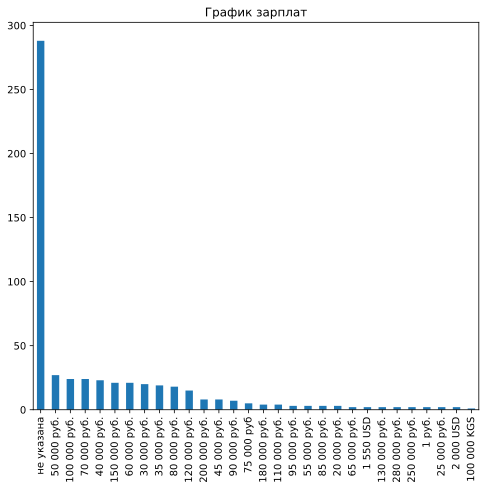

In [ ]:
data['ЗП'].value_counts().iloc[:30].plot(kind='bar')
plt.title('График зарплат')
plt.show()

In [ ]:
data.groupby('ЗП')['ЗП'].count()  #.iloc[400:425]

ЗП
1 200 EUR          1
1 550 USD          2
1 900 000 KZT      1
1 руб.             2
100 000 KGS        1
100 000 руб.      24
110 000 руб.       4
119 000 руб.       1
120 000 руб.      15
127 000 руб.       1
130 000 руб.       2
140 000 руб.       1
150 000 руб.      21
155 000 руб.       1
160 000 руб.       1
170 000 руб.       1
180 000 руб.       4
2 000 USD          2
2 500 USD          1
20 000 руб.        3
200 000 руб.       8
25 000 руб.        2
250 000 руб.       2
280 000 руб.       2
3 000 USD          1
3 500 USD          1
30 000 руб.       20
35 000 руб.       19
350 000 руб.       1
4 000 USD          1
40 000 руб.       23
45 000 руб.        8
50 000 руб.       27
55 000 руб.        3
60 000 руб.       21
600 000 KZT        1
65 000 руб.        2
70 000 руб.       24
75 000 руб         5
80 000 руб.       18
85 000 руб.        3
90 000 руб.        7
95 000 руб.        3
не указана       288
Name: ЗП, dtype: int64

In [ ]:
# Если teDS_df - наш датафрейм # Работаем с колонкой "ЗП"
teDS_df = data
teWColNa_s = "ЗП"
teW_ds = teDS_df[teWColNa_s]
print(f'ColNa4:{teWColNa_s!r} {teW_ds.nunique()} unuque:\n{np.sort(teW_ds.unique())}')
print('', teDS_df.groupby(teWColNa_s).count().iloc[:,0].sort_values(ascending=False), sep='\n')

ColNa4:'ЗП' 44 unuque:
['1 200 EUR' '1 550 USD' '1 900 000 KZT' '1 руб.' '100 000 KGS'
 '100 000 руб.' '110 000 руб.' '119 000 руб.' '120 000 руб.'
 '127 000 руб.' '130 000 руб.' '140 000 руб.' '150 000 руб.'
 '155 000 руб.' '160 000 руб.' '170 000 руб.' '180 000 руб.' '2 000 USD'
 '2 500 USD' '20 000 руб.' '200 000 руб.' '25 000 руб.' '250 000 руб.'
 '280 000 руб.' '3 000 USD' '3 500 USD' '30 000 руб.' '35 000 руб.'
 '350 000 руб.' '4 000 USD' '40 000 руб.' '45 000 руб.' '50 000 руб.'
 '55 000 руб.' '60 000 руб.' '600 000 KZT' '65 000 руб.' '70 000 руб.'
 '75 000 руб' '80 000 руб.' '85 000 руб.' '90 000 руб.' '95 000 руб.'
 'не указана']

ЗП
не указана       288
50 000 руб.       27
70 000 руб.       24
100 000 руб.      24
40 000 руб.       23
60 000 руб.       21
150 000 руб.      21
30 000 руб.       20
35 000 руб.       19
80 000 руб.       18
120 000 руб.      15
45 000 руб.        8
200 000 руб.       8
90 000 руб.        7
75 000 руб         5
110 000 руб.       4
180 000 руб. 

In [ ]:
teMsk_ds = teW_ds == 'не указана' # lделаем маску по значениям "не указана"
teW_ds[teMsk_ds]

1      не указана
3      не указана
9      не указана
10     не указана
12     не указана
          ...    
571    не указана
574    не указана
575    не указана
580    не указана
581    не указана
Name: ЗП, Length: 288, dtype: object

In [ ]:
# отделяем от чисел наименование валюты
teW_ds = teW_ds.astype("string")
teW_ds[teMsk_ds] = pd.NA
teW_df = teW_ds.str.rsplit(' ', n=1, expand=True)
teW_df.columns = [teWColNa_s, "Curr"]
teW_df

,ЗП,Curr
0,90 000,руб.
1,<NA>,<NA>
2,150 000,руб.
3,<NA>,<NA>
4,150 000,руб.
...,...,...
577,70 000,руб.
578,100 000,руб.
579,80 000,руб.
580,<NA>,<NA>


In [ ]:
#выводим валюту
teCurr_s = "Curr"
tMsk_ds = teW_df[teCurr_s].isna()
teCurrV_l = np.sort(teW_df[teCurr_s][~tMsk_ds].unique()).tolist()
print(f'ColNa4:{teCurr_s!r} {teW_df[teCurr_s][~tMsk_ds].nunique()} unuque:\n{teCurrV_l}')
print(teW_df.groupby(teCurr_s).count().iloc[:,0].sort_values(ascending=False))

ColNa4:'Curr' 6 unuque:
['EUR', 'KGS', 'KZT', 'USD', 'руб', 'руб.']
Curr
руб.    274
USD       8
руб       5
KZT       2
EUR       1
KGS       1
Name: ЗП, dtype: int64


In [ ]:
# В переводим валюту в рубли
teWRes_ds = pd.to_numeric(teW_df[teWColNa_s].str.replace(r"\s+", '', regex=True))
assert teMsk_ds.equals(teWRes_ds.isna()), "Che:Up:pd.to_numeric... BOf..."
# See: https://www.banki.ru/products/currency/kgs/ by 1 CurrUnit
tConvCurr_d = dict(zip(teCurrV_l[:-2], [90.39, .95, .19, 83.64]))
print(tConvCurr_d)
for _k, _v in tConvCurr_d.items():
    # print(f"({_k}:{_v})\nBf:", teWRes_ds[teW_df[teCurr_s] == _k], sep='\n')
    teWRes_ds[teW_df[teCurr_s] == _k] *= _v
    # print(f"Af:", teWRes_ds[teW_df[teCurr_s] == _k], '', sep='\n')
teWRes_ds.fillna(0, inplace=True) # Var:1
# teWRes_ds[teMsk_ds] = 0 # Var:2
teWRes_ds

{'EUR': 90.39, 'KGS': 0.95, 'KZT': 0.19, 'USD': 83.64}


0       90000.0
1           0.0
2      150000.0
3           0.0
4      150000.0
         ...   
577     70000.0
578    100000.0
579     80000.0
580         0.0
581         0.0
Name: ЗП, Length: 579, dtype: float64

In [ ]:
#В  выводим информацию о "ЗП" в таблице
teBu_df = teDS_df.copy()
# 4 Restore teDS_df = teBu_df.copy()

teDS_df[teWColNa_s] = teWRes_ds
teDS_df.head()

#Сводная Яч. инфы по teDS_df:
t2Vie_df = teDS_df
display(t2Vie_df)
t2Vie_df.info()
t2Vie_df.describe(include='all')

,Дата отклика,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
0,2023-02-23 00:00:00,Женщина,90000.0,Growth Product Manager,"Индонезия, Не готова к переезду, не готова к к...","проектная работа, частичная занятость, полная ...",удаленная работа,Опыт работы —5 лет 10 месяцев,PT MYBALI APP GROUP,Менеджер по продукту,Маркетинговые исследования\nИсследование рынка...,NaN,Анализ рынка\nУправление проектами\nProduct Ma...,"Высшее, 2023, Нетоло́гия, 2014, Университет Ро...",23 февраля 2023 в 16:30,да
1,2023-01-11 00:00:00,Женщина,0.0,Growth Product Manager,"Москва, Готова к переезду, готова к командировкам",полная занятость,"удаленная работа, гибкий график, полный день",Опыт работы —11 лет 11 месяцев,Банк Открытие,Product owner трайб сбережения и инвестиции,Участие в команде роста\nВ2В\n\nЗадачи:\n- Раз...,NaN,Самомотивация\nТаймменеджмент\nКреативность\nЧ...,"Высшее, 2022, GeekBrains, 2010, Московский худ...",8 февраля 2023 в 09:15,да
2,2023-02-27 00:00:00,"Мужчина, 33 года, родился 23 августа 1989",150000.0,Growth Product Manager,"Санкт-Петербург, Готов к переезду: Москва, гот...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —7 лет 2 месяца,DIKIY LLC,,Запуск бренда и производства игристого кваса D...,"Чем бы я ни занимался с 2014 года, когда решил...",Продвижение бренда\nПланирование маркетинговых...,"Высшее, 2013, Санкт-Петербургский государствен...",28 февраля 2023 в 09:41,да
3,2023-01-11 00:00:00,"Мужчина, 32 года, родился 7 декабря 1990",0.0,Growth Product Manager,"Москва, м. Молодежная, Хочу переехать, готов к...","стажировка, частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",Опыт работы —8 лет 10 месяцев,WeInvest,Product Manager (team leader),1. Исследование рынка\n2. Определение целевой ...,"Я проактивный, коммуникабельный, позитивный, д...",Управление проектами\nОрганизаторские навыки\n...,"Магистр, 2014, Московский государственный техн...",24 января 2023 в 12:07,да
4,2023-01-11 00:00:00,"Мужчина, 26 лет, родился 21 февраля 1996",150000.0,Growth Product Manager,"Пермь, Хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —5 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product/Project manager,Переговоры со стейкхолдером\n- Составление ТЗ...,Набрал кучу опыта и хочу с ним найти классную ...,Управление персоналом\nЗаключение договоров\nА...,"Высшее, 2021, Российская академия народного хо...",6 февраля 2023 в 11:18,да
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,2023-02-28 00:00:00,"Мужчина, 24 года, родился 16 мая 1998",70000.0,Project manager,"Москва, м. Китай-город, Уфа, готов к редким ко...",полная занятость,полный день,Опыт работы —3 года 1 месяц,"Алабуга, ОЭЗ ППТ",HR-специалист,- Обучение и развитие персонала (разработка пр...,"Стрессоустойчивый, коммуникабельный, быстрообу...",Обучение персонала\nУправление командой\nАдапт...,"Высшее, 2020, Казанский (Приволжский) федераль...",27 февраля 2023 в 21:27,NaN
578,2023-02-17 00:00:00,"Мужчина, 42 года, родился 27 марта 1980",100000.0,Project manager,"Уфа, Не готов к переезду, готов к командировкам",полная занятость,"удаленная работа, полный день",Опыт работы —12 лет 8 месяцев,Dental Hall,Директор по развитию и связи с общественностью,Анализ рынка и продукта. Разработка миссии ком...,NaN,Руководство коллективом\nУправление проектами\...,"Среднее специальное, 2002, УФЭК, 2000, УКСиВТ",15 февраля 2023 в 09:17,NaN
579,2023-02-12 00:00:00,"Мужчина, 39 лет, родился 19 октября 1983",80000.0,Project manager,"Уфа, Готов к переезду, готов к командировкам",полная занятость,полный день,Опыт работы —17 лет,"ООО ""Линзы Хойя Рус""","Территориальны

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579 entries, 0 to 581
Data columns (total 16 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Дата отклика                                579 non-null    object 
 1   Пол, возраст                                579 non-null    object 
 2   ЗП                                          579 non-null    float64
 3   Ищет работу на должность                    579 non-null    object 
 4   Город                                       579 non-null    object 
 5   Занятость                                   579 non-null    object 
 6   График                                      579 non-null    object 
 7   Опыт ()                                     579 non-null    object 
 8   Последнее/нынешное место работы             579 non-null    object 
 9   Последняя/нынешняя должность                579 non-null    object 
 10  Выполняемые за

,Дата отклика,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
count,579,579,579.000000,579,579,579,579,579,579,579,552,444,532,579,579,500
unique,89,443,NaN,8,209,20,30,252,486,358,548,418,479,488,547,2
top,2023-02-22 00:00:00,Женщина,NaN,Growth Product Manager,"Уфа, Не готова к переезду, не готова к команди...",полная занятость,полный день,Опыт работы —6 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product manager,Управлял тремя отдельными блокчейн-проектами с...,"Стрессоустойчивый, энергичный, нацелен на резу...",Обучаемость,Среднее образование,31 января 2023 в 09:52,нет
freq,48,41,NaN,198,69,342,202,10,12,42,2,3,9,15,3,489
mean,NaN,NaN,43584.860104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,59914.093348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,70000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.groupby('ЗП')['ЗП'].count()  #.iloc[400:425]

ЗП
0.0         288
1.0           2
20000.0       3
25000.0       2
30000.0      20
35000.0      19
40000.0      23
45000.0       8
50000.0      27
55000.0       3
60000.0      21
65000.0       2
70000.0      24
75000.0       5
80000.0      18
85000.0       3
90000.0       7
95000.0       4
100000.0     24
108468.0      1
110000.0      4
114000.0      1
119000.0      1
120000.0     15
127000.0      1
129642.0      2
130000.0      2
140000.0      1
150000.0     21
155000.0      1
160000.0      1
167280.0      2
170000.0      1
180000.0      4
200000.0      8
209100.0      1
250000.0      2
250920.0      1
280000.0      2
292740.0      1
334560.0      1
350000.0      1
361000.0      1
Name: ЗП, dtype: int64

<Axes: >

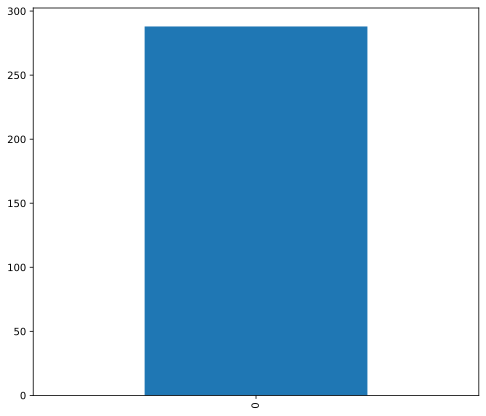

In [ ]:
data[data.groupby('ЗП')['ЗП'].transform('count')>100]['ЗП'].astype('int').value_counts().sort_index().iloc[:30].plot(kind='bar')

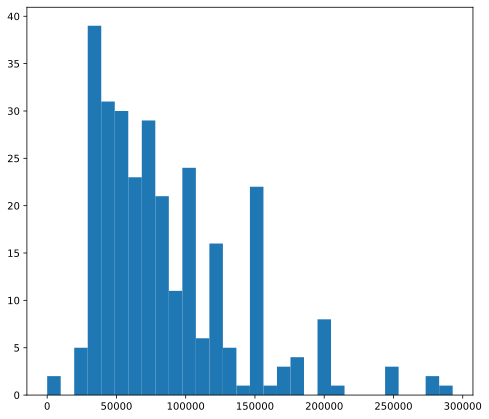

In [ ]:
# plt.hist(data[data['ЗП'] <300000]['ЗП'],  bins=30)
plt.hist(data[(data['ЗП'] <300000) & (data['ЗП'] != 0)]['ЗП'],  bins=30)
plt.show()

<Axes: ylabel='Frequency'>

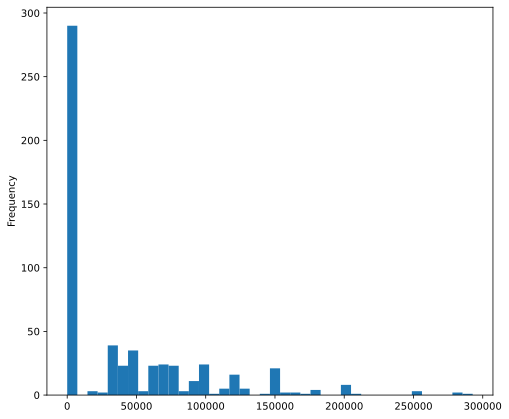

In [ ]:
data[data['ЗП'] <300000]['ЗП'].plot(kind='hist', bins=40)

In [ ]:
# Замена концов строк на пробелы, удаление символа с кодом 0xA0
# обрезка краевых пробелов, приведение к нижнему регистру
def purify(x):
    if isinstance(x, str):                # Если значение - строка:
 #       x = x.replace('\n', ' ').replace('\xa0', '').strip().lower()
        x = x.lower()
    return x

data= data.applymap(purify)
data.head()

,Дата отклика,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
0,2023-02-23 00:00:00,женщина,90000.0,growth product manager,"индонезия, не готова к переезду, не готова к к...","проектная работа, частичная занятость, полная ...",удаленная работа,опыт работы —5 лет 10 месяцев,pt mybali app group,менеджер по продукту,маркетинговые исследования\nисследование рынка...,NaN,анализ рынка\nуправление проектами\nproduct ma...,"высшее, 2023, нетоло́гия, 2014, университет ро...",23 февраля 2023 в 16:30,да
1,2023-01-11 00:00:00,женщина,0.0,growth product manager,"москва, готова к переезду, готова к командировкам",полная занятость,"удаленная работа, гибкий график, полный день",опыт работы —11 лет 11 месяцев,банк открытие,product owner трайб сбережения и инвестиции,участие в команде роста\nв2в\n\nзадачи:\n- раз...,NaN,самомотивация\nтаймменеджмент\nкреативность\nч...,"высшее, 2022, geekbrains, 2010, московский худ...",8 февраля 2023 в 09:15,да
2,2023-02-27 00:00:00,"мужчина, 33 года, родился 23 августа 1989",150000.0,growth product manager,"санкт-петербург, готов к переезду: москва, гот...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",опыт работы —7 лет 2 месяца,dikiy llc,,запуск бренда и производства игристого кваса d...,"чем бы я ни занимался с 2014 года, когда решил...",продвижение бренда\nпланирование маркетинговых...,"высшее, 2013, санкт-петербургский государствен...",28 февраля 2023 в 09:41,да
3,2023-01-11 00:00:00,"мужчина, 32 года, родился 7 декабря 1990",0.0,growth product manager,"москва, м. молодежная, хочу переехать, готов к...","стажировка, частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",опыт работы —8 лет 10 месяцев,weinvest,product manager (team leader),1. исследование рынка\n2. определение целевой ...,"я проактивный, коммуникабельный, позитивный, д...",управление проектами\nорганизаторские навыки\n...,"магистр, 2014, московский государственный техн...",24 января 2023 в 12:07,да
4,2023-01-11 00:00:00,"мужчина, 26 лет, родился 21 февраля 1996",150000.0,growth product manager,"пермь, хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",опыт работы —5 лет 9 месяцев,индивидуальное предпринимательство / частная п...,product/project manager,переговоры со стейкхолдером\n- составление тз...,набрал кучу опыта и хочу с ним найти классную ...,управление персоналом\nзаключение договоров\nа...,"высшее, 2021, российская академия народного хо...",6 февраля 2023 в 11:18,да


In [ ]:
from numba.core.ir import Return
from matplotlib.pylab import rcsetup
# Данные о поле и возрасте
def getParametеrSexAge(arg):
  out = [0,0]
  # Если М, то 1. По умолчанию 0-Ж
  if "M" in arg:
    out[0] = 1
  # текущий год - год рождения
  year_tec = 2023
  if (len(arg)>7):
    out[1]=year_tec-int(re.findall(r'\d{4}', arg)[0])
  return out

  # Полученный возраст превращаем в класс возрастной категории
def getParametеrAgeVect(arg):
    outClass = int((arg-13)/5)
    ourClass = max(0, min(10, outClass))
    # На входе получаем вектор с нужной категорией возраста
    return list(utils.to_categorical(outClass, 11).astype('int'))

In [ ]:
# Разбор значений пола (вариант от елены соколовой измененный для проверки если нет указания на мужчина это или женщина)
def extract_gender(arg):
    if 'женщина' in arg.lower():
        return 0
    elif 'мужчина' in arg.lower():
        return 1
    else:
        return "2"    # указатель что не указано мужчина или женщина

columns =['Пол', 'возраст']
data_clean = pd.DataFrame(data=None, index=None, columns=columns, dtype=None)
data_clean['Пол'] = data['Пол, возраст'].apply(extract_gender)

#data_clean
data_clean['Пол'].value_counts()
#Если нет двоек то все хорошо


1    302
0    277
Name: Пол, dtype: int64

In [ ]:
# Разбор значений пола, возраста

base_update_year = 2023

def extract_sex_age_years(arg):
    # Ожидается, что значение содержит "мужчина" или "женщина"
    # Если "мужчина" - результат 1., иначе 0.
    sex = 1. if 'муж' in arg else 0.

    try:
        # Выделение года и вычисление возраста
        years = base_update_year - int(re.search(r'\d{4}', arg)[0])

    except (IndexError, TypeError, ValueError):
        # В случае ошибки год равен 0
        years = 0

    return sex, years

columns =['Пол', 'возраст']
data_clean = pd.DataFrame(data=None, index=None, columns=columns, dtype=None)
data_clean['Пол', 'возраст'] = data['Пол, возраст'].apply(extract_sex_age_years)

data_clean['Пол'].value_counts()
data_clean

,Пол,возраст,"(Пол, возраст)"
0,NaN,NaN,"(0.0, 0)"
1,NaN,NaN,"(0.0, 0)"
2,NaN,NaN,"(1.0, 34)"
3,NaN,NaN,"(1.0, 33)"
4,NaN,NaN,"(1.0, 27)"
...,...,...,...
577,NaN,NaN,"(1.0, 25)"
578,NaN,NaN,"(1.0, 43)"
579,NaN,NaN,"(1.0, 40)"
580,NaN,NaN,"(0.0, 39)"


In [ ]:
# Выделение подстроки вида ДД.ММ.ГГГГ и возвращение значения года

def extract_year(x):
    try:
        return int(re.search(r'\d\d.\d\d.(\d{4})', x)[1])   # Ожидается строка вида 'dd.mm.yyyy ...'

    except (IndexError, TypeError, ValueError):
        return 0

In [ ]:
def сity_categories(arg):
  millionCities = "Новосибирск Екатеринбург Нижний Новгород Казань Челябинск Омск Самара Ростов-на-Дону Уфа Красноярск Пермь Воронеж Волгоград"
  item= arg.strip() # Удаляем пробелы
  if item == "Москва":          return "Москва"
  if item == "Санкт-Петербург": return "Санкт-Петербург"
  if item in millionCities:     return 'Миллионник'
  else: return "малый или за пределами России город"

In [ ]:
data['Город'] = [сity_categories(cell) for cell in data['Город']]

In [ ]:
data.groupby('Город')['ЗП'].describe().sort_values(by='count',
                                    ascending=False).astype('int')

,count,mean,std,min,25%,50%,75%,max
Город,,,,,,,,
малый или за пределами России город,579,43584,59914,0,0,1,70000,361000


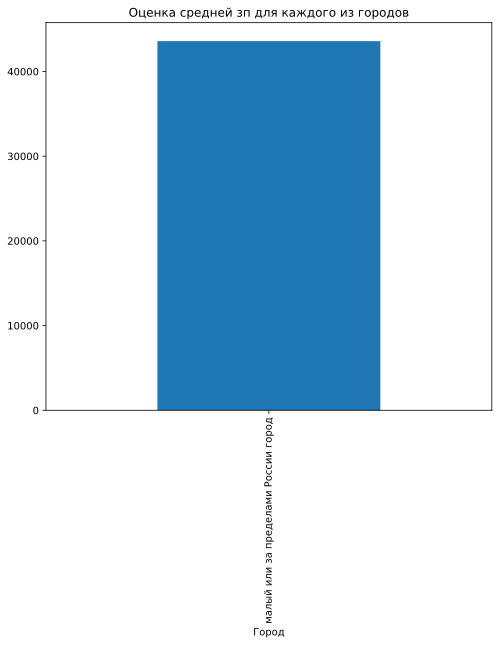

In [ ]:
# Построим график средней ЗП по городам
city = data.groupby('Город')['ЗП'].describe()['mean'].plot(kind = 'bar')
plt.title('Оценка средней зп для каждого из городов')
plt.show()

In [ ]:
data = data.sort_values(by=['ЗП']) # Отсортируем по зарплате
data.head()

,Дата отклика,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
289,2023-02-22 00:00:00,"мужчина, 24 года, родился 10 марта 1998",0.0,product manager в growth hacking команду,малый или за пределами России город,"частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",опыт работы —4 года 6 месяцев,ип здановский а.о.,project manager,"1. ведение проекта со стадии ""идея"" до реализа...",привет! за свой небольшой путь я прошел через ...,ведение переговоров\nработа с большим объемом ...,"магистр, 2023, нижегородский государственный у...",3 марта 2023 в 13:23,нет
275,2023-03-02 00:00:00,"мужчина, 28 лет, родился 5 февраля 1995",0.0,product manager в growth hacking команду,малый или за пределами России город,полная занятость,"удаленная работа, полный день",опыт работы —10 лет 7 месяцев,xway,product manager,● проведение интервью с продавцами\n● построен...,"❏ знание, обучение и применение гибких методол...",управление проектами\ncss\nорганизаторские нав...,"высшее, 2019, национальный исследовательский у...",8 июля 2022 в 14:14,нет
274,2023-02-26 00:00:00,"мужчина, 37 лет, родился 25 октября 1985",0.0,product manager в growth hacking команду,малый или за пределами России город,полная занятость,"удаленная работа, гибкий график, полный день",опыт работы —9 лет 1 месяц,разработка настольных игр,product manager,контроль и ведение интернет проектов \n- анал...,навыки и умения которые я применяю в работе : ...,руководство коллективом\nуправление проектами\...,"неоконченное высшее, 2007, южно-уральский госу...",23 февраля 2023 в 19:29,нет
272,2023-02-27 00:00:00,"мужчина, 26 лет, родился 2 мая 1996",0.0,product manager в growth hacking команду,малый или за пределами России город,полная занятость,"удаленная работа, полный день",опыт работы —5 лет 3 месяца,"агентство ar/vr-разработки ""ar-target""",product manager,- анализ рынка с помощью инструментов google t...,работать в сфере it-разработки на позиции prod...,работа в команде\nproduct management\nмаркетин...,"высшее, 2018, московский автомобильно-дорожный...",3 марта 2023 в 10:32,нет
270,2023-02-27 00:00:00,"женщина, 39 лет, родилась 30 апреля 1983",0.0,product manager в growth hacking команду,малый или за пределами России город,полная занятость,"удаленная работа, гибкий график",опыт работы —13 лет 11 месяцев,медицинский центр лц (в2с),product manager / ux-исследователь,- управление кросс-функциональной командой;\n ...,организовываю полный цикл запуска продукта: un...,cms wordpress\nуправление персоналом\nпроведен...,"высшее, 2005, филиал международного славянског...",27 февраля 2023 в 14:16,нет


# **Не большой итог**
579 строк и 16 колонок, т.е. добавилась 1 колонка

 Все типы данных относятся К dtype: object

Если рассматривать колонки, то например, в колонке обо мне не заполнена информация и если анализировать одно и тоже резюме с разных вариаций датасета, то исчезла перс.инфо (ФИО), но дополнилась информация  в колонке № 10 выполняемые задачи на прошлых местах работ и ключевые навыки , т.е. больше стало инфо о навыках кандидата
Если посмотреть в табличной форме то, из 579 рядов заполнено:
10  Выполняемые задачи на прошлых местах работ  552 non-null    object
 11  Обо мне                                     444 non-null    object
 12  Ключевые навыки                             532 non-null    object
 13  Образование и ВУЗ                           579 non-null    object
 14  Обновление резюме                           579 non-null    object
 15  Подходит - да/нет                           500 non-null    object


 Также как и в первом датасете не указана заработная плата (288-позиций не заполнено)-не известны предпочтения по ЗП как соискателей, так и  какая ЗП установлена работодателем для искомой вакансии.

В запросе по ЗП больше указано в рублях:
 ['EUR', 'KGS', 'KZT', 'USD', 'руб', 'руб.']
Curr
руб.    274
USD       8
руб       5
KZT       2
EUR       1
KGS       1
Рассматривая колонку пол можно увидеть, что пол везде обозначен
Мужчин больше (302), чем женщин (277)
Но так как значение ЗП в большом количестве не указано, то провести сравнительный анализ кто больше запрашивает м ли ж затруднительно.
При первичном анализе видно, что данные обладают рядом проблем, а именно:

не по всем должностям есть примеры кандидатов с положительным вердиктом
не по всем строкам заполнен целевой показатель
данные крайне не сбалансированы (11 положительных примеров (2%) против 489 отрицательных (98%))
Нет понимания какие требования к кандидатам (не указаны трубуемые критерии характеристик к "образцу работника для работодателя").
По указанным выше причинам существует риск, что модель не сможет достоверно предсказывать в критерии выборя "подходит-нет в процентнос соотношении"


# Парсинг Датасета

In [ ]:
# убираем строки, для которых не определен целевой параметр и / или имеются пропуска

data = data.dropna()

In [ ]:
data = data.drop(data.columns[0],axis = 1) # Убираем первый столбец с датой отклика. Он нам не нужен

print(data.shape)

data.head(3)

(356, 15)


,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
289,"мужчина, 24 года, родился 10 марта 1998",0.0,product manager в growth hacking команду,малый или за пределами России город,"частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",опыт работы —4 года 6 месяцев,ип здановский а.о.,project manager,"1. ведение проекта со стадии ""идея"" до реализа...",привет! за свой небольшой путь я прошел через ...,ведение переговоров\nработа с большим объемом ...,"магистр, 2023, нижегородский государственный у...",3 марта 2023 в 13:23,нет
275,"мужчина, 28 лет, родился 5 февраля 1995",0.0,product manager в growth hacking команду,малый или за пределами России город,полная занятость,"удаленная работа, полный день",опыт работы —10 лет 7 месяцев,xway,product manager,● проведение интервью с продавцами\n● построен...,"❏ знание, обучение и применение гибких методол...",управление проектами\ncss\nорганизаторские нав...,"высшее, 2019, национальный исследовательский у...",8 июля 2022 в 14:14,нет
274,"мужчина, 37 лет, родился 25 октября 1985",0.0,product manager в growth hacking команду,малый или за пределами России город,полная занятость,"удаленная работа, гибкий график, полный день",опыт работы —9 лет 1 месяц,разработка настольных игр,product manager,контроль и ведение интернет проектов \n- анал...,навыки и умения которые я применяю в работе : ...,руководство коллективом\nуправление проектами\...,"неоконченное высшее, 2007, южно-уральский госу...",23 февраля 2023 в 19:29,нет


In [ ]:

# Убрать кодировку в описаниях \xa0 \n
i=0
for j in range(15):  # Для каждого из столбцов таблицы (их теперь 15)
    for i in range(data.shape[0]): # По всем резюме
        if type(data.values[i][j])!=float: # если данные текстовые, то заменяем фрагменты кодировки ASCII на отсутствие символов
            data.values[i][j] = data.values[i][j].replace("\xa0","")
            data.values[i][j] = data.values[i][j].replace("\n"," ") # здесь замена перевода строки на пробел

In [ ]:
# Воспроизведение примера данных по индексу (номер строки)
n = 3 # Берем резюме c указанными индексом
for i in range(len(data.values[n])): # Выводим значение каждой графы резюме указанного индекса n
  print(i, " ", data.values[n][i])

0   мужчина, 26 лет, родился 2 мая 1996
1   0.0
2   product manager в growth hacking команду
3   малый или за пределами России город
4   полная занятость
5   удаленная работа, полный день
6   опыт работы —5 лет 3 месяца
7   агентство ar/vr-разработки "ar-target"
8   product manager
9   - анализ рынка с помощью инструментов google trends, google ads, meta insights, yandexwordstat;
- проведение конкурентного анализа в разрезе анализа продукта, сайта, социальных сетей с помощью инструментов similarweb, ahrefs, spywords;
- сегментирование аудитории, проведение custdev;
- формирование маркетинговой стратегии для продвижения агентства: утп , выявление конкурентных преимуществ, создание посадочных страниц, социальных сетей;
- построение бизнес-процессов связанных с маркетингом (запуск ppc-рекламы, smm, настройка crm);
- контроль маркетинговых процессов связанных с работой команды;
- изучение ключевых метрик ar-активаций, рекламных кампаний;
- расчет unit-экономики по внутренним продуктам: ar,

In [ ]:
# Настройка названий столбцов. Избавляет от зависимости использования номера по порядку в таблице

COL_SEX_AGE     = data.columns.get_loc('Пол, возраст')
COL_SALARY      = data.columns.get_loc('ЗП')
COL_POS_SEEK    = data.columns.get_loc('Ищет работу на должность')
COL_CITY        = data.columns.get_loc('Город')
COL_EMPL        = data.columns.get_loc('Занятость')
COL_SCHED       = data.columns.get_loc('График')
COL_EXP         = data.columns.get_loc('Опыт ()')
СOL_CUR_PL_WORK = data.columns.get_loc('Последнее/нынешное место работы')
COL_POS_PREV    = data.columns.get_loc('Последняя/нынешняя должность')
COL_EDU         = data.columns.get_loc('Образование и ВУЗ')
COL_UPDATED     = data.columns.get_loc('Обновление резюме')
СOL_RESULT      = data.columns.get_loc('Подходит - да/нет')
COL_SKILLS      = data.columns.get_loc('Ключевые навыки')
COL_TASKS       = data.columns.get_loc('Выполняемые задачи на прошлых местах работ')
COL_ABOUT       = data.columns.get_loc('Обо мне')

In [ ]:
skills = data.iloc[:, COL_SKILLS]
print(skills)

289    ведение переговоров\nработа с большим объемом ...
275    управление проектами\ncss\nорганизаторские нав...
274    руководство коллективом\nуправление проектами\...
272    работа в команде\nproduct management\nмаркетин...
270    cms wordpress\nуправление персоналом\nпроведен...
                             ...                        
144    стрессоустойчивость, пунктуальность, ответстве...
80     kpi\nавтоматизация процессов\nscrum\nреинжинир...
234    руководство коллективом\nуправление проектами\...
164    управление проектами\nуправление бюджетом\nseo...
181    управление командой\nмотивация персонала\nподб...
Name: Ключевые навыки, Length: 356, dtype: object


In [ ]:
# Функция `purify()` написана для очистки текста в таблице с данными. Она убирает из строки следующие символы:  `\n`; `\xa0`; пробелы по краям.
# А также приводит все символы к нижнему регистру, если надо
def purify(arg):
    if isinstance(arg, str):                # Если значение - строка:
        # Замена концов строк на пробелы, удаление символа с кодом 0xA0,
        # обрезка краевых пробелов и приведение к нижнему регистру
        # arg = arg.replace('\n', ' ').replace('\xa0', '').strip().lower()
        # обрезка краевых пробелов, без  приведения к нижнему регистру
        arg = arg.replace('\n', ' ').replace('\xa0', '')
    return arg

In [ ]:
# Данные о поле и возрасте в поле "Пол, возраст" или COL_SEX_AGE
def getParameterSexAge(arg):
    out = [0, None]   # Второе значение None обозначает отсутствие информации о возрасте
    if "уж" in arg:   # Если есть сочетание  литер "уж", тогда:
        out[0] = 1    # Первое значение поменяется на 1, обозначая мужской пол. Т.Образом, все неизменные - женщины.
    year_tec = 2023   # Устанавливаем текущий год
    if len(arg) > 7:  # Если в поле записано более 7 символов (больше количества букв в словах "Мужчина" или "Женщина", которые есть в каждой строке )
        birth_year = re.findall(r'\d{4}', arg)  # Ищем четыре подряд цифры и находим год рождения
        if birth_year:  # Если определился год рождения, то
            out[1] = year_tec - int(birth_year[0])  # Вычисляем возраст и записываем вторым значением переменной out
    return out          # Вернуть значение out.  В нем вторым заначением останется None, если год рождения так и не нашлось


# Полученный возраст превращаем в класс возрастной категории (первая: от 0 до 17 лет; вторая начинается с совершеннолетия, 18 лет, включительно)
def getParameterAgeVect(arg):
    if arg is None:  # Если возраст равен None, обозначаем его как 0
        arg = 0
    outClass = int((arg - 13) / 5)
    outClass = max(0, min(10, outClass))
    # На выходе получаем вектор с нужной категорией возраста
    return list(utils.to_categorical(outClass, 11).astype('int'))


In [ ]:
# Функция извлечения года из формата dd.mm.yyyy, если она может быть в строке

def extract_year(arg):
    try:                                                    # пробуем выполнить:
        return int(re.search(r'\d\d.\d\d.(\d{4})',arg)[1])  # поиск формы'dd.mm.yyyy' в строке arg, в которой область интереса - в круглых скобках
                                                            # знаение в круглых скобках функция возвращает, если такая форма нашлась
    except (IndexError, TypeError, ValueError):             # если код выполняется с одной из указанных ошибок, не прерываться, а:
        return 0                                            # вернуть значение 0

In [ ]:
# Зарплата
def getParameterSalary(arg):
    if arg.lower().strip() == "не указана":
        return 0

    num = arg
    # Сначала получаем чистое число, убираем лишние знаки
    if (type(num) == str):                      # если  тип  == строка, тогда:
        num = re.sub(' ','',num)                # убираем все пробелы, остаются цифры
        num = re.sub('[а-яА-ЯёЁ]','',num)       # убираем всю кирилицу
        num = re.sub('[a-zA-Z]','',num)         # убираем всю латиницу
        num = num.replace('.','')               # убираем точки

        # Получаем чистую валюту, убираем цифры
        curr = re.sub('[0-9]','',arg)
        curr = curr.replace('.','').strip()

        # Конвертируем в рубли, если валюта (актуализировать курс, если надо!!!)
        if curr == 'USD':
           num = float(num)*65
        elif curr == 'руб':
           num = float(num)*1
        elif curr == 'KZT':
           num = float(num)*0.17
        elif curr=='грн':
           num = float(num)*2.6
        elif curr=='белруб':
           num = float(num)*30.5
        elif curr=='EUR':
           num = float(num)*70
        elif curr=='KGS':
           num = float(num)*0.9
        elif curr=='сум':
           num = float(num)*0.007
        elif curr=='AZN':
           num = float(num)*37.5
        else:
           num = 0  # если нет числового значения, присваиваем 0

    num = float(num)  # Приведение переменной num к типу float
    salaryStr = num/1000000.0      # приводим к млн.руб

    return salaryStr

In [ ]:
def getParameterSalary(arg):

  ''' Функция получения данных о возрасте по году рождения.

  Args:
    arg - строка данных (для данной функции передаем вторую колонку из таблицы)

  Returns: желаемая зарплата (int)

  '''

  out = -1                     # По умолчанию в out записываем -1 (если зарплата не указана)
  if (type(arg) != float):     # Проверяем, чтобы в arg не было float-данных
    index = 0                  # В index запишем позицию последнего пробела во входной строке

    for i in range(len(arg)):  # Пробегаем по всей строке

      if (arg[i]==" "):        # Если очередной символ это пробел
        index = i              # Записываем позицию пробела в index
    salaryStr = ""             # Строковое представление зарплаты

    for i in range(index):     # Пробегаем в цикле от 0 до index (с начала строки до последнего пробела)

      if (i != index-4):       # Если это не пробельный символ в зарплате (в базе зарплата хранится в формате 45 000)
        salaryStr += arg[i]    # Записываем очередной символ в salaryStr
    out = int(salaryStr)       # Преобразуем в int

  return out                   # Возвращаем зарплату

In [ ]:
def getParameterSalaryVector(arg):  # Категориальное представление запроса ЗП:  11 категорий
    out = getParameterSalary(arg)
    outClass = 0
    if out > 0.04:  # если больше 40 тыс
        outClass = 1
    if out > 0.06:  # если больше 60 тыс
        outClass = 2
    if out > 0.1:  # если больше 100 тыс
        outClass = 3
    if out > 0.12:  # если больше 120 тыс
        outClass = 4
    if out > 0.18:  # если больше 180 тыс
        outClass = 5
    if out > 0.25:  # если больше 250 тыс
        outClass = 6
    if out > 0.4:  # если больше 400 тыс
        outClass = 7
    if out > 0.6:  # если больше 600 тыс
        outClass = 8
    if out > 0.8:  # если больше 800 тыс
        outClass = 9
    if out > 1:  # если больше 1 млн
        outClass = 10

    return list(utils.to_categorical(outClass, 11).astype('int'))

In [ ]:
# парсинг поля "город" (COL_CITY) на три категории: СOL_CITY; COL_RELOCATION; COL_BUSINESS_TRIP
def parse_field_City(arg):
    parts = arg.split(',')

    COL_CITY = parts[0].strip() if len(parts) >= 1 else ""                        # все что до первой запятой
    COL_BUSINESS_TRIP = parts[-1].strip() if len(parts) >= 3 else ""              # все что после последней запятой
    COL_RELOCATION = ', '.join(parts[1:-1]).strip() if len(parts) >= 3 else ""    # все что между первой и последней зпт

    # Преобразование категории "COL_BUSINESS_TRIP"
    if "редким" in COL_BUSINESS_TRIP:
        COL_BUSINESS_TRIP = "редко"
    elif "не частым" in COL_BUSINESS_TRIP:
        COL_BUSINESS_TRIP = "редко"
    elif "нечастым" in COL_BUSINESS_TRIP:
        COL_BUSINESS_TRIP = "редко"
    elif "не готова" in COL_BUSINESS_TRIP:
        COL_BUSINESS_TRIP = "нет"
    elif "не готов" in COL_BUSINESS_TRIP:
        COL_BUSINESS_TRIP = "нет"
    else:
        COL_BUSINESS_TRIP = "да"

    return COL_CITY, COL_RELOCATION, COL_BUSINESS_TRIP

In [ ]:
# Данные о городе
def getParameterCity(arg):
  MillionCities = "Новосибирск Екатеринбург Нижний Новгород Казань Челябинск Омск Самара Ростов-на-Дону Уфа Красноярск Пермь Воронеж Волгоград"
  Abroad = "Австралия, Австрия, Ямайка, Армения, Бельгия, Сербия, Великобритания, Швеция, Германия, Дания, Израиль, Ирландия, Испания, Италия, Канада, Исландия, Бангладеш, Мальта, Китай, Андорра, Иран, Лихтенштейн, Монако, Мексика, Босния и Герцеговина, Черногория, Непал, Хорватия, Македония, Филиппины, Сент-Винсент и Гренадины, Латвия, Словения, Бахрейн, Ливия, Королевство Саудовская Аравия, Литва, Кувейт, Индонезия, Иордания, Молдавия, Словакия, Ливан, Алжир, Нидерланды, Колумбия, Республика Маврикий, Марокко, Чехия, Болгария, Польша, Вьетнам, Новая Зеландия, Люксембург, Норвегия, Шри-Ланка, ОАЭ, Индия, Катар, ЮАР, Другое, США, Греция, Турция, Финляндия, Франция, Сингапур, Румыния, Аргентина, Швейцария, Кипр, Эстония, Южная Корея, Малайзия, Мальдивская Республика, Япония, Шотландия, Нигерия, Португалия, Венгрия, Бразилия, Багамские Острова"
  if arg in Abroad:            return [1, 0, 0, 0, 0]
  if "Москва" in arg:          return [0, 1, 0, 0, 0]
  if "Санкт-Петербург" in arg: return [0, 0, 1, 0, 0]
  if  arg in MillionCities:    return [0, 0, 0, 1, 0]
  return [0, 0, 0, 0, 1]

In [ ]:
# Данные о командировке:
def getParameterBUSINESS_TRIP(arg):
  out= [0, 0]
  if ("да" in arg):     out[0]=1
  if ("редко" in arg):  out[1]=1
  return out

In [ ]:
# Метки Заказчика в ДС
def getResult(arg):
  out = 0
  if isinstance(arg, str) and "да" in arg:      # проверка, является ли строкой подаваемый в функцию аргумент. Если нет, то out останется = 0
    out = 1
  return int(out)                               # приводим к целочисленному значению

In [ ]:
# Данные о желаемой занятости
def getParameterEmployment(arg):
  out= [0, 0, 0, 0, 0]
  if ("стажир" in arg):       out[0]=1
  if ("волонт" in arg):       out[1]=1
  if ("частич" in arg):       out[2]=1
  if ("неп" in arg):          out[2]=1
  if ("проект" in arg):       out[3]=1
  if ("полн" in arg):         out[4]=1
  return out

In [ ]:
# Данные о желаемом графике работы
def getParameterSchedule(arg):
  out = [0, 0, 0, 0, 0]
  if ("гибк" in arg):         out[0]=1
  if ("полн" in arg):         out[1]=1
  if ("смен" in arg):         out[2]=1
  if ("удал" in arg):         out[3]=1
  if ("нная" in arg):         out[3]=1
  if ("вахт" in arg):         out[4]=1
  return out

In [ ]:
def getParameterEducation(arg):
  out = [0, 0, 0, 0, 0, 0]    # По умолчанию не указано
  if "андидат" in arg:                               out[0] = 1
  if "Высшее," in arg or "igher" in arg:             out[1] = 1   #применимо только, если строку не приводить к нижнему регистру
  if "пециаль" in arg or "редн" in arg:              out[2] = 1
  if "агистр" in arg:                                out[3] = 1
  if "акалав" in arg:                                out[4] = 1
  if " высшее" in arg:                               out[5] = 1  # "Неоконченное высшее," != "Высшее,"

  if sum(out) == 0:  # Если не найдено ни одного ключевого слова
    return out  # Возвращаем список [0, 0, 0, 0, 0, 0]

  return out

In [ ]:
# Разбор данных поля об опыте работы - результат в месяцах

def extract_experience_months(arg):
    try:
        # Выделение количества лет, преобразование в int
        years = int(re.search(r'(\d+)\s+(год.?|лет)', arg)[1])

    except (IndexError, TypeError, ValueError):
        # Если ошибка, не прерываемся: устанавливаем количество лет равно 0
        years = 0

    try:
        # Выделение количества месяцев, преобразование в int
        months = int(re.search(r'(\d+)\s+месяц', arg)[1])

    except (IndexError, TypeError, ValueError):
        # Неудача - количество месяцев равно 0
        months = 0

    # Возврат результата в месяцах
    return years * 12 + months


    # Категориальное представление опыта работы
def getParameterExperienceVector(arg):
  out = extract_experience_months(arg)
  outClass = 0
  if (out > 6): # если больше 6 месяцев
    outClass = 1
  if (out > 12): # если больше 12 месяцев
    outClass = 2
  if (out > 24): # если больше 24 месяцев
    outClass = 3
  if (out > 36): # если больше 36 месяцев
    outClass = 4
  if (out > 60): # если больше 60 месяцев
    outClass = 5
  if (out > 96): # если больше 96 месяцев
    outClass = 6
  if (out > 120): # если больше 120 месяцев
    outClass = 7
  if (out > 156): # если больше 156 месяцев
    outClass = 8
  if (out > 192): # если больше 192 месяцев
    outClass = 9
  if (out > 240): # если больше 240 месяцев
    outClass = 10

  return list(utils.to_categorical(outClass, 11).astype('int'))

In [ ]:
# Разбор данных о городe и преобразование в one hot encoding.
# Работает со словарем типа "Классы городов" (в отдельной ячейке)

def extract_city_to_ohe(arg):
    # Определение размерности выходного вектора
    num_classes = city_class[0]

    # Разбивка текста в arg на отдельные слова
    split_array = re.split(r'[ ,.:()?!]', arg)   # В данном случае, шаблон разделителя указан как [ ,.:()?!], который соответствует символам
                                                 # пробела, запятой, точки, двоеточия, круглых скобок, вопросительного и восклицательного знаков.
                                                 # Это означает, что всякий раз, когда встречается любой из этих символов, строка arg будет разделена на подстроки
                                                 # Пустые строки '' возникают там, где два символа-разделителя идут подряд (например, между запятой и пробелом)
    # Поиск города в строке и присвоение ему класса
    for word in split_array:
        city_cls = city_class[1].get(word, -1)   # Эта строка пытается получить значение, связанное с ключом word в словаре city_class[1].
                                                 #Если ключ word найден в словаре, то city_cls будет содержать соответствующее значение.
                                                 # Если ключ word отсутствует в словаре, то city_cls будет равно -1 (значение по умолчанию,
                                                 # указанное вторым аргументом метода get())
        if city_cls >= 0:                        # Если это условие выполняется, то цикл for прерывается. Это означает, что если элемент word
                                                 # из split_array соответствует какому-либо ключу в словаре city_class[1] и явл. положительным
            break                                # значением класса city_cls, то цикл будет прерван
    else:                                 # Внимание: for/else
        # Город не в city_class - значит его класс "прочие города"
        city_cls = num_classes - 1

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(city_cls, num_classes)

In [ ]:
# Классы городов
city_class = [0,
              {'москва'          : 0,
               'санкт-петербург' : 1,
               'новосибирск'     : 2,
               'екатеринбург'    : 2,
               'нижний новгород' : 2,
               'казань'          : 2,
               'челябинск'       : 2,
               'омск'            : 2,
               'самара'          : 2,
               'ростов-на-дону'  : 2,
               'уфа'             : 2,
               'красноярск'      : 2,
               'пермь'           : 2,
               'воронеж'         : 2,
               'волгоград'       : 2,
               'прочие города'   : 3
              }]

# Вычисление счетчика для данных разбиения
for class_desc in [city_class]:     # в [] может быть список таких же словарей и списков заданных порогов, например такого типа:
  # Список порогов возраста:
  # age_class = [0, [18, 23, 28, 33, 38, 43, 48, 53, 58, 63]]
  # где первым элементом тоже стоит позиция для счетчика
    if isinstance(class_desc[1], list):                 # если вторая часть списка представлена типом данных "список" (list) (как age_class), то:
        class_desc[0] = len(class_desc[1]) + 1          # счетчик class_desc[0] устанавливается равным количеству элементов в списке class_desc[1],
                                                        # увеличенному на 1. Это счетчик представляет количество классов в данном случае.
    else:                                               # Если тип данных в class_desc[1] не является списком, то считается, что это словарь (dict).
        class_desc[0] = max(class_desc[1].values()) + 1 # В этом случае  счетчик class_desc[0] устанавливается равным максимальному значению в
                                                        # словаре class_desc[1], увеличенному на 1. Этот счетчик также представляет кол-во классов.

In [ ]:
# Классы занятости
employment_class = [5,                      # либо установить вручную количество классов, либо использовать код определения (выше)
                    {'стажировка'          : 0,
                     'волонтерство'        : 1,
                     'не полная занятость' : 2,
                     'частичная занятость' : 2,
                     'неполная занятость'  : 2,
                     'проектная работа'    : 3,
                     'полная занятость'    : 4
                    }]

In [ ]:
# Общая функция преобразования строки к multi-вектору
# На входе данные и словарь сопоставления подстрок классам

def str_to_multi(arg, class_dict):
    # Определение размерности выходного вектора
    num_classes = class_dict[0]

    # Создание нулевого вектора
    result = np.zeros(num_classes)

    # Поиск значения в словаре и, если найдено,
    # выставление 1. на нужной позиции
    for value, cls in class_dict[1].items():
        if value in arg:
            result[cls] = 1.

    return result

In [ ]:
# Разбор данных о желаемой занятости и преобразование в multi

def extract_employment_to_multi(arg):
    return str_to_multi(arg, employment_class)

In [ ]:
# Список порогов возраста
age_class = [11, [18, 23, 28, 33, 38, 43, 48, 53, 58, 63]]


In [ ]:
def int_to_ohe(arg, class_list):

    # Определение размерности выходного вектора
    num_classes = class_list[0]

    # Поиск верного интервала для входного значения
    for i in range(num_classes - 1):
        if arg < class_list[1][i]:
            cls = i                       # Интервал найден - назначение класса
            break
    else:                                 # Внимание: for/else
        cls = num_classes - 1             # Интервал не найден - последний класс

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(cls, num_classes)

In [ ]:
# Классы целевой должности. (оставил вариант 1)
pos_class = [6,                     # либо установить вручную количество классов, либо использовать код определения класса (выше)
                    {'прочее'                                              : 0,
                     'Product Manager'                                     : 1,
                     'Growth Product Manager'                              : 1,
                     'Product Marketing Manager в Growth Hacking команду'  : 1,
                     'Product manager в Growth Hacking команду'            : 1,
                     'HR-специалист'                                       : 2,
                     'Product Manager в команду HR'                        : 2,
                     'Project manager'                                     : 3,
                     'Директор медицинской клиники'                        : 4,
                     'Product Manager в команду Финансового департамента'  : 5
                    }]
# функция преобразования строки к multi-вектору

def str_to_multi(arg, pos_class):
    # Определение размерности выходного вектора
    num_classes = pos_class[0]

    # Создание нулевого вектора
    result = np.zeros(num_classes)

    # Поиск значения в словаре и, если найдено,
    # выставление 1. на нужной позиции
    for value, cls in pos_class[1].items():
        if value in arg:
            result[cls] = 1.

    return result

In [ ]:
# Выкачиваю данные по текущему месту работы и должности
def getXTrainTProf(values):
  xTrainTProf = []

  for val in values:
    currText = ""
    if (type(val[СOL_CUR_PL_WORK]) != float):
      currText += val[СOL_CUR_PL_WORK]
    if (type(val[COL_POS_PREV ]) != float):
      currText += " " + val[COL_POS_PREV]

    xTrainTProf.append(currText)

  xTrainTProf = np.array(xTrainTProf)

  return xTrainTProf

In [ ]:
# Вытаскиваю из дататсета текстовые данные для выборки
xTrainTProf = getXTrainTProf(data.values)
print(xTrainTProf[17])              # пример места работы и должности из [n]-го резюме

билайн менеджер проекта интернет вещей


# Функции извлечения всех параметров

In [ ]:
# Функция извлечения всех параметров (кроме текстовых об текущей работе, образовании, навыков, задач и информации о себе) и преобразования в вектор
def extract_row_data(row):

    # Извлечение и преобразование данных
    sex, age = getParameterSexAge(row[COL_SEX_AGE])                  # Пол, возраст
    sex_vec = np.array([sex])                                        # Пол в виде вектора
    age_vec = getParameterAgeVect(age)                               # Возраст в виде вектора
    city_vec = getParameterCity(parse_field_City(row[COL_CITY])[0])  # Город
    empl = extract_employment_to_multi(row[COL_EMPL])                # Тип занятости
    sched_vec = getParameterSchedule(row[COL_SCHED])                 # График работы
    educ_vec = getParameterEducation(row[COL_EDU])                   # Образование
    exper_vec = getParameterExperienceVector(row[COL_EXP])           # Опыт работы в месяцах
    salary_vec = getParameterSalaryVector(row[COL_SALARY])           # Зарплата в виде вектора
    bisunestrip = getParameterBUSINESS_TRIP(parse_field_City(row[COL_CITY])[2])  # Готовность к командировкам
    pos_vec = str_to_multi(row[COL_POS_SEEK], pos_class)             # Целевая должность в виде вектора
    result = getResult(row[СOL_RESULT])                              # результат разметки Заказчиком

    # Объединение всех входных данных в один общий вектор
    x_data = np.hstack([sex_vec,
                        age_vec,
                        city_vec,
                        empl,
                        sched_vec,
                        educ_vec,
                        exper_vec,
                        salary_vec,
                        bisunestrip,
                        pos_vec])

    # Возврат входных данных и выходных (результат разметки)
    return x_data, result


# Создание общей выборки
def construct_train_data(row_list):
    x_data = []
    y_data = []

    for row in row_list:
        x, y = extract_row_data(row)
        # if y[0] > 0:                      # Вариант добавления данных только при выполнении заданного условия по значениям датасета (вариации могут быть разными, в нашем случае это не нужно)
        x_data.append(x)
        y_data.append(y)

    return np.array(x_data), np.array(y_data)

In [ ]:
# Формирование выборки из загруженного набора данных
x_train_02, y_train = construct_train_data(data.values)

In [ ]:
# Форма наборов параметров и результата
print('x_train.shape:', x_train_02.shape)
print('y_train.shape:', y_train.shape)

# Пример обработанных данных
n = 4
print('Пример результата векторизации данных в строке n (x_train[n]):', x_train_02[n])
print('Пример результата векторизации данных в строке n (y_train[n]):', y_train[n])

x_train.shape: (356, 63)
y_train.shape: (356,)
Пример результата векторизации данных в строке n (x_train[n]): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Пример результата векторизации данных в строке n (y_train[n]): 0


# Нейронка по простым данным

Используем задачи регрессии для оценки пригодности кандидата на основе табличных данных из резюме, можно использовать нейронную сеть с выходным слоем, который будет предсказывать числовое значение. Однако, если на выходе должно быть только оценка в форме "подходит" или "не подходит"

In [ ]:
import numpy as np #Библиотека работы с массивами
import pandas as pd # Библиотека для работы с базами

from tensorflow.keras.models import Sequential, Model #
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten #
from tensorflow.keras import utils #Используем для to_categoricall
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop #
from tf.keras.optimizers.legacy.Adam.
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence #
from tensorflow.keras.preprocessing.sequence import pad_sequences #
from tensorflow.keras.callbacks import LambdaCallback # подключаем колбэки
# Добавим библиотеки для создания модели нейронной сети и оценки ее качества
import tensorflow as tf
# Разделение на обучающую и проверочную/тестовую выборку


from sklearn.preprocessing import StandardScaler #
from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error #
from sklearn.utils import class_weight
#from google.colab import files #Для загрузки своей картинки

import random #Для генерации случайных чисел
import math # Для округления
#import os #Для работы с файлами
import re #
import matplotlib.pyplot as plt #
%matplotlib inline

from IPython.display import clear_output

Epoch 1/50
5/5 - 2s - loss: 0.2468 - mae: 0.3871 - val_loss: 0.0582 - val_mae: 0.2004 - 2s/epoch - 423ms/step
Epoch 2/50
5/5 - 0s - loss: 0.0352 - mae: 0.1276 - val_loss: 0.0493 - val_mae: 0.1184 - 287ms/epoch - 57ms/step
Epoch 3/50
5/5 - 0s - loss: 0.0244 - mae: 0.0966 - val_loss: 0.0374 - val_mae: 0.0483 - 346ms/epoch - 69ms/step
Epoch 4/50
5/5 - 0s - loss: 0.0118 - mae: 0.0390 - val_loss: 0.0364 - val_mae: 0.0472 - 243ms/epoch - 49ms/step
Epoch 5/50
5/5 - 0s - loss: 0.0110 - mae: 0.0440 - val_loss: 0.0365 - val_mae: 0.0494 - 253ms/epoch - 51ms/step
Epoch 6/50
5/5 - 0s - loss: 0.0097 - mae: 0.0362 - val_loss: 0.0366 - val_mae: 0.0491 - 420ms/epoch - 84ms/step
Epoch 7/50
5/5 - 0s - loss: 0.0084 - mae: 0.0297 - val_loss: 0.0366 - val_mae: 0.0463 - 376ms/epoch - 75ms/step
Epoch 8/50
5/5 - 0s - loss: 0.0079 - mae: 0.0261 - val_loss: 0.0367 - val_mae: 0.0462 - 464ms/epoch - 93ms/step
Epoch 9/50
5/5 - 0s - loss: 0.0068 - mae: 0.0247 - val_loss: 0.0369 - val_mae: 0.0500 - 449ms/epoch - 90ms

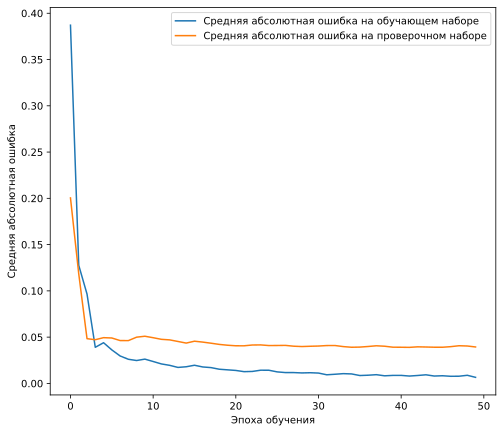

In [ ]:
model = Sequential()
model.add(BatchNormalization(input_shape=(x_train_02.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(1000, activation='tanh'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(lr=1e-5), loss='mse', metrics=['mae'])

history = model.fit(x_train_02,
                    y_train,
                    epochs=50,
                    batch_size=64,
                    validation_split=0.15,
                    verbose=2)

plt.plot(history.history['mae'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [ ]:
# Делаем предсказание и приводим его к начальному виду
pred=model.predict(x_train_02)
pred=pred.flatten()
# Среднее значение ошибки
delta=pred-y_train
absDelta=abs(delta)
print(sum(absDelta) / len(absDelta))

12/12 [==============================] - 0s 3ms/step
0.012713874729148771


На графике видно, что идет снижение ошибки и значения на графике не совпадает со значением предсказания

In [ ]:
# В качестве нормализации данных используем готовую библиотеку
yScaler = StandardScaler()

# Скармливаем объекту двухмерный вектор
yScaler.fit(y_train.reshape(-1,1))

# Нормализуем по нормальному распределению
yTrainScaled = yScaler.transform(y_train.reshape(-1, 1))

print(yTrainScaled.shape)
print(y_train[1])
print(yTrainScaled[1])


(356, 1)
0
[-0.13093073]


In [ ]:
print(min(y_train), max(y_train))
print(min(yTrainScaled), max(yTrainScaled))

0 1
[-0.13093073] [7.63762616]


Epoch 1/50
5/5 - 3s - loss: 0.9551 - mae: 0.4296 - val_loss: 2.5411 - val_mae: 0.6004 - 3s/epoch - 616ms/step
Epoch 2/50
5/5 - 0s - loss: 0.7213 - mae: 0.4175 - val_loss: 2.1420 - val_mae: 0.6064 - 197ms/epoch - 39ms/step
Epoch 3/50
5/5 - 0s - loss: 0.5942 - mae: 0.2943 - val_loss: 2.2683 - val_mae: 0.3384 - 141ms/epoch - 28ms/step
Epoch 4/50
5/5 - 0s - loss: 0.5247 - mae: 0.2203 - val_loss: 2.2350 - val_mae: 0.3375 - 130ms/epoch - 26ms/step
Epoch 5/50
5/5 - 0s - loss: 0.3514 - mae: 0.2036 - val_loss: 2.2077 - val_mae: 0.3377 - 194ms/epoch - 39ms/step
Epoch 6/50
5/5 - 0s - loss: 0.3513 - mae: 0.1996 - val_loss: 2.2123 - val_mae: 0.3415 - 164ms/epoch - 33ms/step
Epoch 7/50
5/5 - 0s - loss: 0.2498 - mae: 0.1957 - val_loss: 2.2178 - val_mae: 0.3473 - 202ms/epoch - 40ms/step
Epoch 8/50
5/5 - 0s - loss: 0.2589 - mae: 0.1859 - val_loss: 2.2132 - val_mae: 0.3408 - 171ms/epoch - 34ms/step
Epoch 9/50
5/5 - 0s - loss: 0.2230 - mae: 0.1494 - val_loss: 2.1790 - val_mae: 0.3504 - 131ms/epoch - 26ms

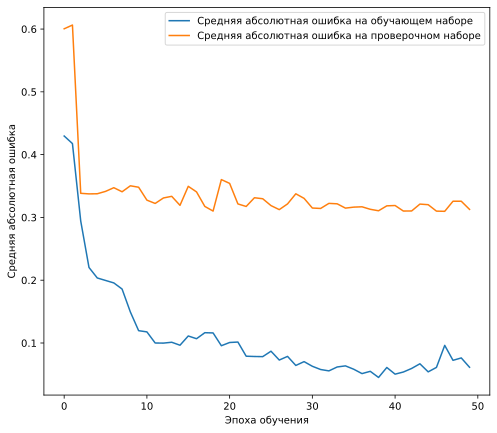

In [ ]:
# Обучаем модель стандартизированными данными
modelS = Sequential()
modelS.add(BatchNormalization(input_shape=(x_train_02.shape[1],)))
modelS.add(Dense(128, activation='relu'))
modelS.add(Dense(1000, activation='tanh'))
modelS.add(Dense(100, activation='relu'))
modelS.add(Dense(1, activation='linear'))

modelS.compile(optimizer=Adam(lr=1e-5), loss='mse', metrics=['mae'])

history = modelS.fit(x_train_02,
                    yTrainScaled,
                    epochs=50,
                    batch_size=64,
                    validation_split=0.15,
                    verbose=2)

plt.plot(history.history['mae'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [ ]:
# Делаем предсказание и приводим его к начальному виду
pred = modelS.predict(x_train_02)
predUnscaled = yScaler.inverse_transform(pred).flatten()

# Среднее значение ошибки
delta = predUnscaled - y_train
absDelta = abs(delta)
print(sum(absDelta) / len(absDelta))

12/12 [==============================] - 0s 4ms/step
0.013205532354118843


После стандартизации данных показатель ошибки немного вырос

# Оценка результатов

In [ ]:
yy = model.predict(x_train_02) # Результат для всего тренировочного набора

12/12 [==============================] - 0s 3ms/step


In [ ]:
n = 10
for i in range(n):
  print('Реальное значение - ',y_train[i], " Предсказанное значение - ", yy[i][0], " Разница - ", abs(y_train[i]-yy[i][0]))

Реальное значение -  0  Предсказанное значение -  0.011388233  Разница -  0.011388232931494713
Реальное значение -  0  Предсказанное значение -  0.000496658  Разница -  0.000496657972689718
Реальное значение -  0  Предсказанное значение -  0.000496658  Разница -  0.000496657972689718
Реальное значение -  0  Предсказанное значение -  0.000496658  Разница -  0.000496657972689718
Реальное значение -  0  Предсказанное значение -  -0.00036106672  Разница -  0.0003610667190514505
Реальное значение -  0  Предсказанное значение -  0.0039491537  Разница -  0.0039491537027060986
Реальное значение -  0  Предсказанное значение -  -0.0013550599  Разница -  0.0013550599105656147
Реальное значение -  0  Предсказанное значение -  0.0002082079  Разница -  0.00020820790086872876
Реальное значение -  0  Предсказанное значение -  0.000496658  Разница -  0.000496657972689718
Реальное значение -  0  Предсказанное значение -  0.023044802  Разница -  0.023044802248477936


In [ ]:
# Загружаю и готовлю данные для предсказаний
# Загрузка файла.xlsx
data_pr = data

In [ ]:
# Формирование выборки из загруженного набора данных. Назову ее тестовой


x_test, y_test = construct_train_data(data.values)  # В варианте использования функции

In [ ]:
# Форма наборов параметров и результата
print('x_test.shape:',x_test.shape)
print('y_test.shape:',y_test.shape)

# Пример обработанных данных
n = 7
print('Пример результата векторизации данных в строке n (x_test[n]):', x_test[n])
print('Пример результата векторизации данных в строке n (y_test[n]):', y_test[n])

x_test.shape: (356, 63)
y_test.shape: (356,)
Пример результата векторизации данных в строке n (x_test[n]): [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Пример результата векторизации данных в строке n (y_test[n]): 0


In [ ]:
# Проверка работы сети - предсказание на "тестовой" выборке
pred = model.predict(x_test)
# Для более легкого восприятия данных:
predictions = pred.flatten()  # Преобразование в одномерный массив
predictions = [1 if p >= 0.5 else 0 for p in predictions]  # Преобразование вероятностей в метки "да" (1) или "нет" (0)
print(pred)
print(predictions)
sum(predictions)

12/12 [==============================] - 0s 3ms/step
[[ 1.1388233e-02]
 [ 4.9665797e-04]
 [ 4.9665797e-04]
 [ 4.9665797e-04]
 [-3.6106672e-04]
 [ 3.9491537e-03]
 [-1.3550599e-03]
 [ 2.0820790e-04]
 [ 4.9665797e-04]
 [ 2.3044802e-02]
 [-1.3129788e-03]
 [ 2.0820790e-04]
 [ 5.4935557e-03]
 [ 4.8474438e-04]
 [ 4.9665797e-04]
 [-3.0028966e-04]
 [ 4.9665797e-04]
 [-1.9118213e-03]
 [-6.9668633e-05]
 [-2.7716367e-03]
 [ 4.9665797e-04]
 [ 4.9665797e-04]
 [ 6.2131812e-04]
 [-7.1031210e-04]
 [-6.5605971e-05]
 [-2.3062334e-03]
 [ 2.5689481e-03]
 [-6.5665576e-05]
 [ 2.0820790e-04]
 [ 4.9665797e-04]
 [-1.9027689e-03]
 [ 1.0665471e-04]
 [ 4.8689642e-03]
 [ 4.9665797e-04]
 [-2.5343683e-03]
 [ 5.5004272e-04]
 [-1.4227000e-03]
 [ 4.8689642e-03]
 [ 4.4841305e-04]
 [ 6.6819967e-04]
 [-6.9668633e-05]
 [-8.8347594e-04]
 [ 3.3971148e-03]
 [ 5.6716315e-03]
 [ 4.9665797e-04]
 [-2.8106947e-03]
 [ 7.8684534e-06]
 [ 6.5252762e-03]
 [ 2.0820790e-04]
 [ 4.9665797e-04]
 [ 4.9665797e-04]
 [-3.7911464e-04]
 [-7.468024

3

Вывод: использая данный вид НС с учетом выборки параметров, видно переобучение НС, Заказчиком не предоставлен нужный критерий отбора кандидата для необходимого обучения НС, процент со значением "нет" намного велик по сравнению с положительным вердиктом при несбалансированном датасете.